# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Clone `torchvision` repository the access the detection model helpers

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.1

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 13197 (delta 76), reused 42 (delta 13), pack-reused 13056
Receiving objects: 100% (13197/13197), 15.52 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (9188/9188), done.
Note: checking out 'v0.8.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 45f960c [release/0.8] packaging: Add version suffix to build version (#2913)


# Initialization

Provide seed for the random number generator to limit the number of nondeterministic behaviors and improve the reducibility

In [ ]:
import numpy as np
np.random.seed(0)

In [ ]:
import torch
torch.manual_seed(0)

# Create a custom Pytorch's dataset

## Read the dataset

The dataset contains the name of the filename of the image, and the annotations of that image in CSV format. The dataset is splitted into the train dataset and a dev dataset.

In [ ]:
import os
import pandas as pd

# The directory the contains the dataset
DATA_DIR = '/content/drive/MyDrive/mip2020_datasets/object-CXR/'

# We only train the model on the images with annotations
labels_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), na_filter=False)
labels_train = labels_train.loc[labels_train['annotation'].astype(bool)]
labels_train = labels_train.reset_index(drop=True)

labels_dev = pd.read_csv(os.path.join(DATA_DIR, 'dev.csv'), na_filter=False)

print("LABELS_TRAIN:")
print(labels_train.head(5))
print("================================")
print("LABELS_DEV:")
print(labels_dev.head(5))

LABELS_TRAIN:
  image_name             annotation
0  00005.jpg  0 2076 1559 2369 1695
1  00006.jpg  0 1368 2587 1692 3039
2  00007.jpg     0 944 188 2064 806
3  00008.jpg   0 730 1720 1897 2673
4  00009.jpg   0 847 1346 1345 1877
LABELS_DEV:
  image_name            annotation
0  08001.jpg   0 539 1036 897 1460
1  08002.jpg                      
2  08003.jpg                      
3  08004.jpg  0 828 1607 1181 2021
4  08005.jpg                      


We need to create a custom `Dataset` class to represents our data to PyTorch. The class contains methods that helps with data loading and data batching.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

# Annotations for the same image are separated by a semicolon
SEP_OBJECT = ';' 
# Elements of an annotation are separated by a single space
SEP_ANNOTATION = ' '


class ObjectCXRDataset(torch.utils.data.Dataset):

  def __init__(self, root, dtype='train', transform=None, labels={}):
    self.root = root
    self.dtype = dtype
    self.transform = transform
    self.image_names = [name for name in sorted(os.listdir(root)) 
                        if name in labels.keys()]
    self.annotations = [labels[name] for name in self.image_names]

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, self.image_names[idx])
    img = Image.open(img_path).convert('RGB')
    W, H = img.size

    if self.dtype == 'train':
      boxes = []
      annos = self.annotations[idx]

      if type(annos) == str:
        for anno in annos.split(SEP_OBJECT):
          xs = []
          ys = []
          for i, elem in enumerate(anno.split(SEP_ANNOTATION)[1:]):
            if i % 2 == 0:
              xs.append(float(elem))
            else:
              ys.append(float(elem))

          x_min = min(xs) / W * 600
          y_min = min(ys) / H * 600
          x_max = max(xs) / W * 600
          y_max = max(ys) / H * 600
          boxes.append([x_min, y_min, x_max, y_max])

      image_id = torch.tensor([idx])
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.ones((len(boxes),), dtype=torch.int64)
      iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
      area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

      target = {}
      target["image_id"] = image_id
      target["boxes"] = boxes
      target["labels"] = labels
      target["iscrowd"] = iscrowd
      target["area"] = area
      
      if self.transform is not None:
          img = self.transform(img)
          
      return img, target

    elif self.dtype == 'dev':
      if self.annotations[idx] == '':
        label = 0
      else:
        label = 1
      
      if self.transform is not None:
        img = self.transform(img)

      return img, label, W, H

Having the class defined, we create a dataset for training and a dataset for evalutation. For the model to read the image, it has to be resized and normalized. We will use the Faster-RCNN model with a ResNet backbone, so the prepocessing the ImageNet is used.

In [ ]:
import torchvision

# ImageNet normalization parameters
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

data_transforms = torchvision.transforms.Compose([
  torchvision.transforms.Resize((600, 600)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

labels_train_dict = dict(zip(labels_train.image_name, labels_train.annotation))
data_train = ObjectCXRDataset(os.path.join(DATA_DIR, 'train'),
                              dtype='train',
                              transform=data_transforms,
                              labels=labels_train_dict)

labels_dev_dict = dict(zip(labels_dev.image_name, labels_dev.annotation))
data_dev = ObjectCXRDataset(os.path.join(DATA_DIR, 'dev'),
                            dtype='dev',
                            transform=data_transforms,
                            labels=labels_dev_dict)

Create data loaders that help with data batching, shuffling, and parallel access.

In [ ]:
import utils

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=8,
                                                shuffle=True,
                                                num_workers=4,
                                                collate_fn=utils.collate_fn)

data_loader_dev = torch.utils.data.DataLoader(data_dev,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=4,
                                              collate_fn=utils.collate_fn)

## View the dataset

In [ ]:
from PIL import ImageDraw

def draw_annotations(img, annos, fill=(255, 63, 63, 40)):
  img_draw = ImageDraw.Draw(img, mode='RGBA')
  for anno in annos.split(SEP_OBJECT):
    anno = list(map(int, anno.split(SEP_ANNOTATION)))
    if anno[0] == 0:
      img_draw.rectangle(anno[1:], fill=fill)
    elif anno[0] == 1:
      img_draw.ellipse(anno[1:], fill=fill)
    else:
      img_draw.polygon(anno[1:], fill=fill)

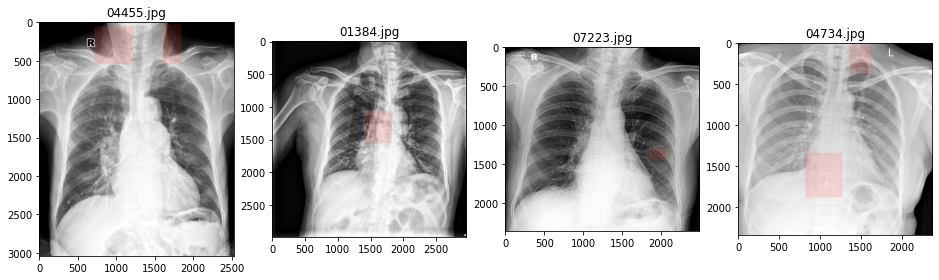

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 16))
eg_labels = labels_train.sample(n = 4).itertuples(index=False)

for labels, ax in zip(eg_labels, axs):
  img_path = os.path.join(DATA_DIR, f'train/{labels.image_name}')
  img = Image.open(img_path).convert('RGB')
  if labels.annotation:
    draw_annotations(img, labels.annotation)
  
  ax.imshow(img)
  ax.set_title(f"{labels.image_name}")

# Create the model

## Define the model

The model is based on the Faster-RCNN architecture with the ResNet50 backbone. Pretrained weights will be downloaded and loaded into our network. The final classification layer will be replaced by our specifically defined layer, which outputs two classes, object and background.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def transfer_faster_rcnn_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

## Train the model

First we create a function that train the model using the given parameters and calculates the values of ACC and AUC after each epoch for evaluation.

In [ ]:
from engine import train_one_epoch
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def train_model(model, optimizer, lr_scheduler, data_loader_train, data_loader_eval, epochs=5):
  auc_max = 0
  for epoch in range(epochs):
    train_one_epoch(model,
                    optimizer,
                    data_loader_train,
                    TORCH_DEVICE,
                    epoch,
                    print_freq=50)
    lr_scheduler.step()

    print("================================================================")
    print(f"EVALUATION FOR EPOCH {epoch}")
    model.eval()
    predicts = []
    labels = []
    for image, label,  width, height in tqdm(data_loader_eval):
      labels.append(label[-1])
      image = list(img.to(TORCH_DEVICE) for img in image)
      outputs = model_ft(image)
      boxes = outputs[-1]['boxes']
      scores = outputs[-1]['scores']
      if len(boxes) != 0:
        predicts.append(torch.max(scores).tolist())
      else:
        predicts.append(0)
    
    predict_labels = []
    for p in predicts:
      if p >= 0.5:
        predict_labels.append(1)
      else:
        predict_labels.append(0)
            
    corrects = 0
    for label_predict, label_truth in zip(predict_labels, labels):
      if label_predict == label_truth:
        corrects += 1

    acc = corrects / len(predict_labels)  
    auc = roc_auc_score(labels, predicts)
    print(f"ACC: {acc:.4f} | AUC: {auc:.4f}")
    if auc > auc_max:
      auc_max = auc
      print("Best epoch found!")
      torch.save(model_ft.state_dict(), PATH_MODEL_WEIGHTS)
    print("================================================================")

The model is then trained using "Stochastic Gradient Descent" with momentum and weight decay. The global step learning rate scheduler scaled the learning rate as the number of epochs increases.

In [ ]:
NUM_CLASSES = 2
TORCH_DEVICE = torch.device('cuda')
PATH_MODEL_WEIGHTS = "/content/drive/MyDrive/Colab Notebooks/object_cxr_detection_model.pt"

model_ft = transfer_faster_rcnn_model(NUM_CLASSES)
model_ft.to(TORCH_DEVICE)

params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [ ]:
train_model(model_ft, optimizer, lr_scheduler,
            data_loader_train, data_loader_dev, epochs=5)

# Output the CSV

In [ ]:
from tqdm import tqdm

model = transfer_faster_rcnn_model(NUM_CLASSES)
model.to(TORCH_DEVICE)
model.load_state_dict(torch.load(PATH_MODEL_WEIGHTS))
model.eval()

# preds contains the probability of the CT image contains at least one foreign object
preds = []
# locs contains the boxes' center locations, along with the model confident in the prediction
locs = []

for image, _, width, height in tqdm(data_loader_dev):  
  center_points = []
  center_points_preds = []

  image = list(img.to(TORCH_DEVICE) for img in image)  
  outputs = model(image)
  boxes = outputs[-1]['boxes']
  scores = outputs[-1]['scores']

  if len(boxes) != 0: # no foreign object
    preds.append(torch.max(scores).tolist())
    confident_idx = torch.where(scores > 0.1)
    boxes = boxes[confident_idx]
    scores = scores[confident_idx]

    for box in boxes:
        new_box = box.tolist()
        center_x = (new_box[0] + new_box[2]) / 2
        center_y = (new_box[1] + new_box[3]) / 2
        center_points.append([center_x / 600 * width[-1],
                              center_y / 600 * height[-1]])
    center_points_preds += scores.tolist()
    
    line = ''
    for i in range(len(boxes)):
        if i == len(boxes)-1:
            line += str(center_points_preds[i]) + ' ' + str(center_points[i][0]) + ' ' + str(center_points[i][1])
        else:
            line += str(center_points_preds[i]) + ' ' + str(center_points[i][0]) + ' ' + str(center_points[i][1]) +';'
    locs.append(line)
    
  else:
    preds.append(0)
    center_points.append([])
    center_points_preds.append('')
    locs.append('')

100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


In [ ]:
result_classification = pd.DataFrame({'image_name': data_dev.image_names,
                                      'prediction': preds})
result_classification.to_csv('classification.csv',
                             columns=['image_name', 'prediction'],
                             sep=',',
                             index=None)

result_localization = pd.DataFrame({'image_name': data_dev.image_names,
                                    'prediction': locs})
result_localization.to_csv('localization.csv',
                           columns=['image_name', 'prediction'],
                           sep=',',
                           index=None)

# Calculate AUC and ACC

In [ ]:
from sklearn.metrics import roc_curve, auc

predicts = result_classification.prediction.values
truths = labels_dev.annotation.astype(bool).astype(float).values

# label = 1 if prediction is more than 50% confident
acc = ((predicts >= .5) == truths).mean()

# false positive rate and True positive rate
fpr, tpr, _ = roc_curve(truths, predicts)
roc_auc = auc(fpr, tpr)

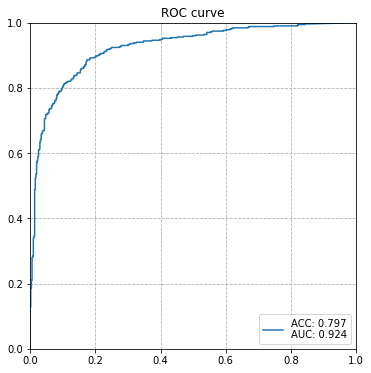

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(xlim=[0, 1],
                                       ylim=[0, 1], aspect='equal'),
                       figsize=(6, 6))

ax.plot(fpr, tpr, label=f'ACC: {acc:.03}\nAUC: {roc_auc:.03}')
_ = ax.legend(loc="lower right")
_ = ax.set_title('ROC curve')
ax.grid(linestyle='dashed')

# Calculate FROC

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/MIP/object-cxr-baseline/froc.py $DATA_DIR"dev.csv" "localization.csv"

False positives per image:
0.125	0.25	0.5	1	2	4	8
Sensitivity:
0.572	0.688	0.806	0.851	0.888	0.888	0.888
FROC:
0.7971850809289233


<Figure size 432x288 with 0 Axes>